In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
# nltk.download('stopwords')
from nltk.corpus import stopwords
import tensorflow as tf

import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding, Flatten
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, optimizers, layers
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint


# !pip install -q -U keras-tuner
import kerastuner as kt

import IPython


from sklearn.model_selection import train_test_split

import re

from nltk import pos_tag
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer 

from gensim.models import word2vec

from IPython.display import display 

import seaborn as sns
import matplotlib.pyplot as plt
from src import load_text, get_word_index


sns.set(context = 'notebook', style = 'whitegrid')
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows',50)

Below text thanks to:https://www.kaggle.com/jjjohnson/experiments-sentiment-analysis-raw-data-gru-lstm/edit

https://towardsdatascience.com/hands-on-nlp-deep-learning-model-preparation-in-tensorflow-2-x-2e8c9f3c7633

GloVe embeddigns thanks to Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation. [pdf] [bib]




Thanks to https://keras.io/examples/nlp/pretrained_word_embeddings/ and Kefei Mo https://towardsdatascience.com/hands-on-nlp-deep-learning-model-preparation-in-tensorflow-2-x-2e8c9f3c7633 

for the below

In [28]:
df = load_text(sentences=True, grammarize=True)
word_index = get_word_index(df)

489

In [38]:
# !python -m spacy download en_core_web_lg
# nlp = spacy.load('en_core_web_lg')


# num_words = len(word_index.keys())
# print(f'total vocabulary length: {num_words}')


num_tokens = num_words + 1
embedding_dim = len(nlp('the').vector)
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():

    try:
        embedding_matrix[i+1] = nlp(word).vector
        hits += 1
    except:
        misses +=1
print(f'words converted: {hits}, words not found: {misses}')
tokens = df.Text.apply(lambda text: [word_index[word] for word in text.split()])
X = pad_sequences(tokens, padding='post')
y = df.Grade


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, random_state = 42, test_size = 0.2)

words converted: 1, words not found: 0


In [40]:
X_train.shape

(7252, 263)

In [41]:
embedding_layer=Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False)
version = 0

In [42]:
def make_model():

    model = Sequential()

    model.add(embedding_layer)
    model.add(LSTM(50, return_sequences=True))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4)))    
    model.add(Dense(1))

    adam = optimizers.Adam(learning_rate=.01, decay=1e-2)
    model.compile(optimizer = adam, loss = 'mean_absolute_error', metrics = None)
    
    return model
model = make_model()
filepath = 'model1-best.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss',verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         3494700   
_________________________________________________________________
lstm (LSTM)                  (None, None, 50)          70200     
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                3264      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4

Epoch 1/50
59/59 [==============================] - ETA: 0s - loss: 2.9680
Epoch 00001: val_loss improved from inf to 2.70620, saving model to model1-best.hdf5
59/59 [==============================] - 16s 272ms/step - loss: 2.9680 - val_loss: 2.7062
Epoch 2/50
59/59 [==============================] - ETA: 0s - loss: 2.5800
Epoch 00002: val_loss did not improve from 2.70620
59/59 [==============================] - 12s 201ms/step - loss: 2.5800 - val_loss: 3.0087
Epoch 3/50
59/59 [==============================] - ETA: 0s - loss: 2.4725
Epoch 00003: val_loss did not improve from 2.70620
59/59 [==============================] - 12s 208ms/step - loss: 2.4725 - val_loss: 2.8903
Epoch 4/50
59/59 [==============================] - ETA: 0s - loss: 2.3837
Epoch 00004: val_loss did not improve from 2.70620
59/59 [==============================] - 12s 211ms/step - loss: 2.3837 - val_loss: 2.8342
Epoch 5/50
59/59 [==============================] - ETA: 0s - loss: 2.2914
Epoch 00005: val_loss impro

Epoch 38/50
59/59 [==============================] - ETA: 0s - loss: 1.4942
Epoch 00038: val_loss did not improve from 2.32252
59/59 [==============================] - 24s 401ms/step - loss: 1.4942 - val_loss: 2.5582
Epoch 39/50
59/59 [==============================] - ETA: 0s - loss: 1.5034
Epoch 00039: val_loss did not improve from 2.32252
59/59 [==============================] - 24s 403ms/step - loss: 1.5034 - val_loss: 2.5209
Epoch 40/50
59/59 [==============================] - ETA: 0s - loss: 1.5066
Epoch 00040: val_loss did not improve from 2.32252
59/59 [==============================] - 24s 413ms/step - loss: 1.5066 - val_loss: 2.5712
Epoch 41/50
59/59 [==============================] - ETA: 0s - loss: 1.4614
Epoch 00041: val_loss did not improve from 2.32252
59/59 [==============================] - 20s 336ms/step - loss: 1.4614 - val_loss: 2.5760
Epoch 42/50
59/59 [==============================] - ETA: 0s - loss: 1.4508
Epoch 00042: val_loss did not improve from 2.32252
59/59

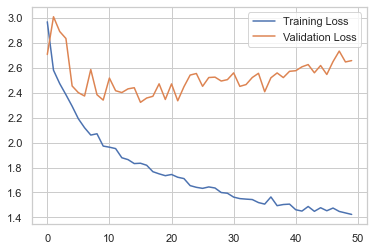

OSError: SavedModel file does not exist at: /content/model1-best.hdf5/{saved_model.pbtxt|saved_model.pb}

In [43]:
history = model.fit(X_train, y_train,
                     batch_size=100,
                     epochs=50,
                     validation_split=.2,
                    callbacks=callbacks)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

model = keras.models.load_model('/content/model1-best.hdf5')
yhat = model.predict(X_test).ravel()
print('MAE = ', np.sum(np.abs(y_test-yhat))/len(y_test))
print('mean grade prediction = ',np.mean(model.predict(X_train)))
print('mean grade = ', np.mean(y_train))

errors = df.loc[y_test.index][['Text','Grade']]
errors['Predicted Grade'] = yhat
errors.sample(5)

In [ ]:
def make_model2():

    model = Sequential()

    model.add(embedding_layer)
    model.add(LSTM(50, return_sequences=True))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4)))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4)))  
    model.add(Dense(32, activation='relu', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4)))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='relu', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4)))  
    model.add(Dense(1))

    adam = optimizers.Adam(learning_rate=.01, decay=1e-2)
    model.compile(optimizer = adam, loss = 'mean_absolute_error', metrics = None)
    
    return model
model = make_model2()
print(model.summary())
filepath = 'model2-best.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss',verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]



In [ ]:
history = model.fit(X_train, y_train,
                     batch_size=100,
                     epochs=50,
                     validation_split=.2,
                    callbacks=callbacks)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

model = keras.models.load_model('/content/model2-best.hdf5')
yhat = model.predict(X_test).ravel()
print('MAE = ', np.sum(np.abs(y_test-yhat))/len(y_test))
print('mean grade prediction = ',np.mean(model.predict(X_train)))
print('mean grade = ', np.mean(y_train))

errors = df.loc[y_test.index][['Text','Grade']]
errors['Predicted Grade'] = yhat
errors.sample(5)